In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk import FreqDist
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import defaultdict
from nltk import bigrams
from sklearn.feature_selection import chi2
from collections import Counter



# Predicting the Genres of Songs by their Lyrics

Navigating music's vast landscape, we often rely on genres to classify songs. In this project, we apply machine learning techniques to predict whether a song is pop, rock or rap based on its lyrics. Using natural language processing, we'll identify the key phrases that set these genres apart.

| <center>Pop</center> | <center>Rock</center> | <center>Rap</center> |
|----------|----------|----------|
| <img src="pictures/arianagrande.png" width="300"> | <img src="pictures/metallica.png" width="300"> | <img src="pictures/snoopdog.jpg" width="300"> |
| Ooh-ooh-ooh-ooh | Darkness, imprisoning me | Right back up in your mothafuckin' ass
Love me, love me, love me |  All that I see, absolute horror | 9-5 plus four pennies, add that shit up
Ooh-ooh-ooh-ooh | I cannot live, I cannot die | D.R.E. right back up on top of thangs
Harder (you gotta love me harder) | Trapped in myself, body my holding cell | Smoke some wit' your Dogg



## Table Of Contents

In [15]:
artists_df = pd.read_csv('data/artists-data.csv')
lyrics_df = pd.read_csv('data/lyrics-data.csv',delimiter=',', quotechar='"')

### Data Preprocessing
Before we can analyze the data, we need to preprocess it. This includes standardizing the column with the link to the artist's account and merging the two datasets on this column.
We are going to work with English songs only for this project.


In [16]:
# remove leading/trailing spaces if any
artists_df['Link'] = artists_df['Link'].str.strip()
lyrics_df['ALink'] = lyrics_df['ALink'].str.strip()

# merge the datasets on the link to the artist's account
merged_df = pd.merge(lyrics_df, artists_df, left_on='ALink', right_on='Link', how='left')

 Dropping the rows with missing lyrics or genres

In [17]:
# handle missing values (drop rows with missing lyrics or genres)
merged_df.dropna(subset=['Lyric', 'Genres'], inplace=True)

# Replace \r and \n in 'Lyric' only if the entry is a string
merged_df['Lyric'] = merged_df['Lyric'].apply(lambda x: x.replace('\r', '').replace('\n', ' ') if isinstance(x, str) else x)



 Filtering Out Non-English Songs

In [18]:
# identify artists with Non-English songs
nonenglish_artists = set(merged_df[merged_df['language'] != 'en']['Artist'].unique())

# remove all rows related to artists who have Non-English songs
merged_df = merged_df[~merged_df['Artist'].isin(nonenglish_artists)]


## Data Exploration - The Initial "Flop"
Taking a look at the genres available in the data. Over a 100 genres not evenly distributed at all.
 **And that's when I decided I will work with 3 genres only!**

Total unique genres: 113

First 6 most common genres:
 Rock: 11091
Rock: 5660
Country: 5599
 Hip Hop: 5550
Rap: 4985
 Pop: 4643

Last 2 genres:
Electro Swing: 6
K-Pop/K-Rock: 2


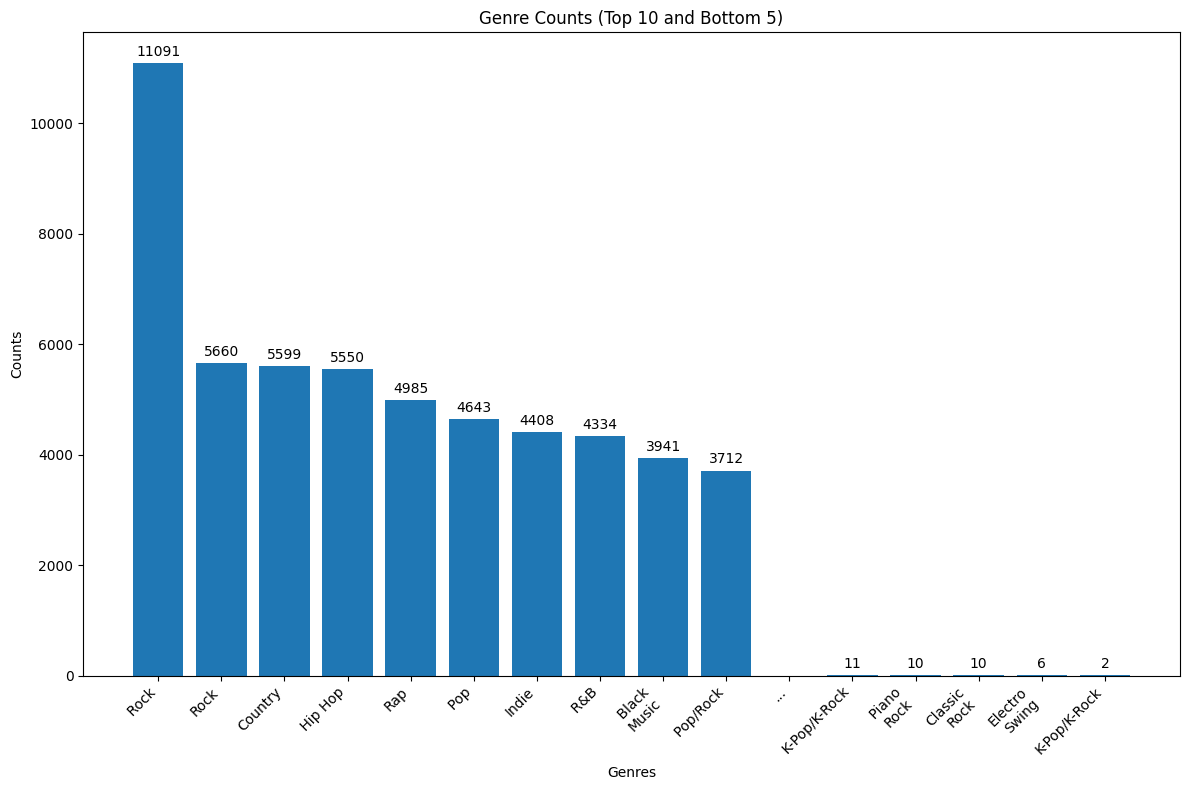

In [19]:

# splitting the genres and creating a flat list
all_genres = [genre for sublist in merged_df['Genres'].dropna() for genre in sublist.split(';')]

# counting the occurrences of each genre
genre_counts = Counter(all_genres)

# display the total count of unique genres
total_unique_genres = len(genre_counts)
print(f"Total unique genres: {total_unique_genres}")

# displaying the first 6 most common genres
print("\nFirst 6 most common genres:")
for genre, count in genre_counts.most_common(6):
    print(f"{genre}: {count}")

# displaying the last 2 genres
# if there are fewer than 8 genres, this will display however many there are, not repeating the first 6
print("\nLast 2 genres:")
for genre, count in list(genre_counts.most_common())[-2:]:
    print(f"{genre}: {count}")


all_genres = [genre for sublist in merged_df['Genres'].dropna() for genre in sublist.split(';')]

# Counting the occurrences of each genre
genre_counts = Counter(all_genres)

# Creating lists for the genres and their counts
genres = [genre for genre, count in genre_counts.items()]
counts = [count for genre, count in genre_counts.items()]

# Assuming all_genres and genre_counts are already defined as before
# Get the top 10 and bottom 5 genres
top_10_genres = genre_counts.most_common(10)
bottom_5_genres = genre_counts.most_common()[-5:]

# Combine them with ellipses in between
combined_genres = top_10_genres + [('...', 0)] + bottom_5_genres

# Separate the genres and their counts for plotting
genres = [item[0] for item in combined_genres]
counts = [item[1] for item in combined_genres]

# Function to wrap text for genre labels
def wrap_text(text, max_length=10):
    if len(text) > max_length:
        split_index = text.find(' ', max_length // 2)
        if split_index != -1:
            return text[:split_index] + '\n' + text[split_index + 1:]
    return text

# Wrap genre names for labels
wrapped_genres = [wrap_text(genre) for genre in genres]

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.bar(wrapped_genres, counts)
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.title('Genre Counts (Top 10 and Bottom 5)')
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability

# Optional: Add counts above bars
for bar in bars:
    height = bar.get_height()
    if height > 0:  # Skip the ellipsis bar
        plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()


Standardizing the genres - removing whitespace, splitting multiple ones described as one (hybrid genres, they are going to be too complicated to work with).

In [20]:
# function to standardize genre names
# ensure 'Genres' is a string and split genres into a list
merged_df['Genres'] = merged_df['Genres'].astype(str).apply(lambda x: x.split(';'))

# Standardize genres by stripping whitespace and converting to lowercase
def standardize_genres(genre_list):
    standardized = [genre.strip().lower() for genre in genre_list]
    return standardized

merged_df['Genres'] = merged_df['Genres'].apply(standardize_genres)

# keep hybrid genres as is
hybrid_genres = {genre for genre in all_genres if '/' in genre}
print("Hybrid genres:", hybrid_genres)

# Split hybrid genres into individual genres
def standardize_genres(genre_list):
    standardized = []
    for genre in genre_list:
        if '/' in genre:  # Detect hybrid genres
            standardized.extend(genre.split('/'))  # Split and extend the list
        else:
            standardized.append(genre.strip().lower())
    return standardized

merged_df['Genres'] = merged_df['Genres'].apply(standardize_genres)


Hybrid genres: {' K-Pop/K-Rock', 'Pop/Punk', 'Gospel/Religioso', 'Pop/Rock', ' J-Pop/J-Rock', ' Gospel/Religioso', ' Pop/Punk', 'K-Pop/K-Rock', ' Pop/Rock'}


Now that the genres are stardartized, let's get rid of the unneeded ones. However, there is still an issue with multiple genre songs.
Primarily because the genre column is linked to the artist more than to the specific song. 
**So we are only going to work with artists/songs that have only ONE of the genres we are looking for.** Another interesting option would be treating a pop/rock song as both, but the result sounds too scary for now. Going back to the project after a while, I could try doing it this way.

In [21]:
# define the genres of interest
genres_of_interest = ['pop', 'rock', 'rap']

# gilter for songs that have at least one of the genres of interest and are in English
filtered_songs_df = merged_df[
    merged_df['language'] == 'en'  # Songs must be in English
].copy()

# include songs that have any of the genres of interest
filtered_songs_df = filtered_songs_df[
    filtered_songs_df['Genres'].apply(lambda genres: any(genre in genres_of_interest for genre in genres))
]

# filter the DataFrame to include songs with exactly one of the genres of interest
exclusive_genre_songs_df = filtered_songs_df[
    filtered_songs_df['Genres'].apply(lambda genres: sum(genre in genres_of_interest for genre in genres) == 1)
].copy()

# extract the relevant genre from the list
exclusive_genre_songs_df['Single_Genre'] = exclusive_genre_songs_df['Genres'].apply(
    lambda genres: next(genre for genre in genres if genre in genres_of_interest)
)

# Check how many songs contain any of the genres of interest
print("Songs with any of the genres of interest:", len(filtered_songs_df))

# Check how many songs are exclusively categorized under one of the genres of interest
print("Songs with exactly one of the genres of interest:", len(exclusive_genre_songs_df))






Songs with any of the genres of interest: 33204
Songs with exactly one of the genres of interest: 25952


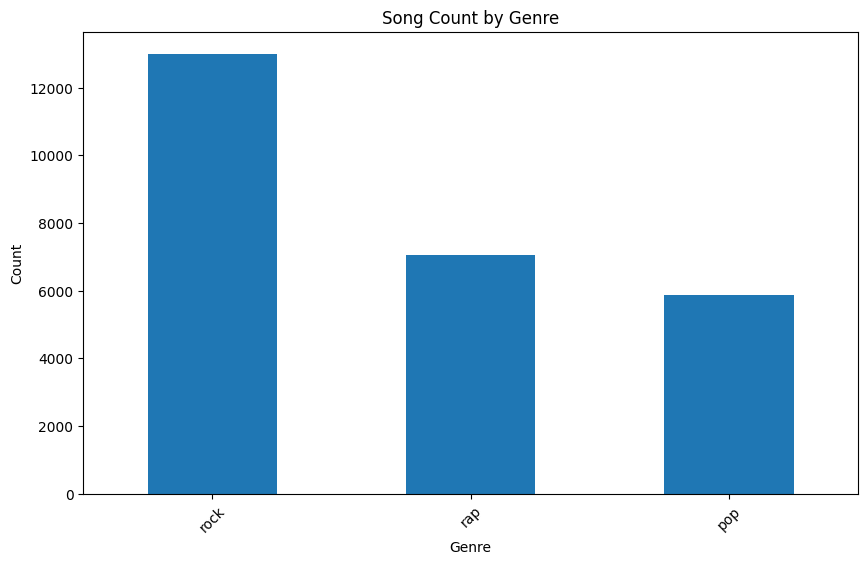

In [22]:
# filter for songs that are exclusively categorized as one of the genres of interest
# explode the 'Genres' column into separate rows
exploded_genres = exclusive_genre_songs_df['Single_Genre'].explode()

# filter for only genres of interest
genre_counts = exploded_genres[exploded_genres.isin(genres_of_interest)].value_counts()


# create a bar chart of genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Song Count by Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()




The amount of rock songs is twice the amount of the others, let's remove half of them randomly so that they are all about equal (so that the model is not biased towards any genre).

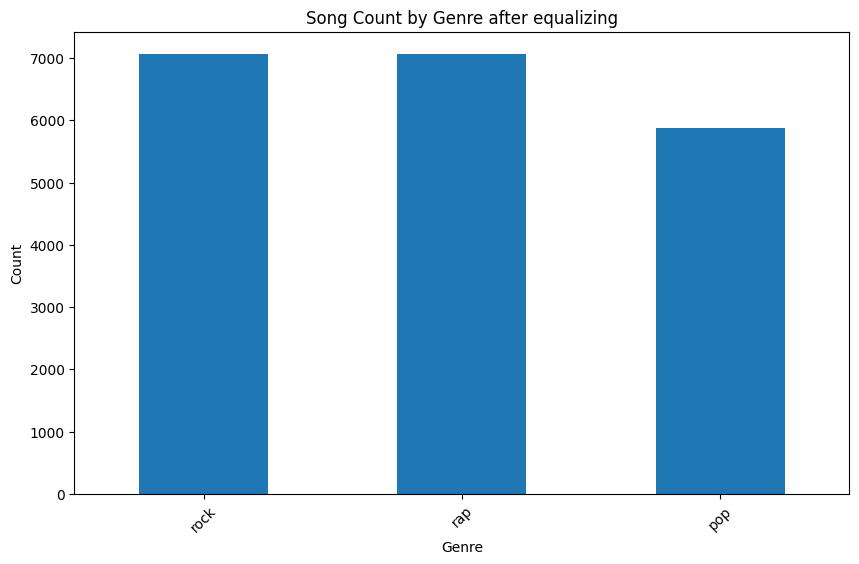

In [23]:
pop_songs = exclusive_genre_songs_df[exclusive_genre_songs_df['Single_Genre'] == 'pop']
rock_songs = exclusive_genre_songs_df[exclusive_genre_songs_df['Single_Genre'] == 'rock']
rap_songs = exclusive_genre_songs_df[exclusive_genre_songs_df['Single_Genre'] == 'rap']

# Find the number of songs to match
target_song_count = max(len(pop_songs), len(rap_songs))

# Downsample the rock songs
rock_songs_downsampled = rock_songs.sample(n=target_song_count, random_state=42)

balanced_songs_df = pd.concat([pop_songs, rock_songs_downsampled, rap_songs], ignore_index=True)

balanced_songs_df = balanced_songs_df.sample(frac=1, random_state=42).reset_index(drop=True)


exploded_genres = balanced_songs_df['Single_Genre'].explode()

# filter for only genres of interest
genre_counts = exploded_genres[exploded_genres.isin(genres_of_interest)].value_counts()


# create a bar chart of genres
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Song Count by Genre after equalizing')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()



Here is how our data looks in the table so far:

In [24]:
# Create a sample DataFrame with truncated lyrics
sample_df = balanced_songs_df.sample(n=10).copy()
sample_df['Lyric'] = sample_df['Lyric'].str[:30] + '...'

# Rename the columns to match the desired output
sample_df.rename(columns={
    'SName': 'song',
    'Artist': 'artist',
    'Single_Genre': 'genre',
    'Lyric': 'lyric'
}, inplace=True)

# Select only the columns we want to display
sample_df = sample_df[['song', 'artist', 'genre', 'lyric']]
sample_df


,song,artist,genre,lyric
6717,I Wanna Stay,Smith/Kotzen,rock,"I wanna stay, I wanna lay Rest..."
10754,Youth (Feat. Khalid),Shawn Mendes,pop,"Here I am, stuck on this couch..."
3136,Moldy Bread,Sebadoh,rock,A troubled babyâ€™s raised on ...
7593,Wasted,Gucci Mane,rap,[Hook:] Rockstar lifestyle mig...
4547,Morning Final,Blue Öyster Cult,rock,He cast a grim shadow Through ...
7686,Good Life,Nate Dogg,rap,"(feat. Nas, JS) [Nate Dogg & ..."
5152,Midnight Fantasy,Victoria Beckham,pop,Its half past twelve and I'm o...
12979,Hate To Let You Go,Austin Mahone,pop,Ever had a thought about us? I...
5768,Summer Is Over,Sara Bareilles,pop,Autumn never seemed this cold ...
4428,Bad Side,T-Pain,rap,Yeeahh Wooohooo Shawty.. Yee...


Let's take a look at the most common unigrams and bigrams in the currently available lyrics:

In [25]:

from sklearn.feature_extraction import text 

default_stopwords = text.ENGLISH_STOP_WORDS

# additional custom stopwords
additional_stopwords = { 'reproduced', 'directed', 'starring'}

# Combine the default and custom stopwords
all_stopwords = default_stopwords.union(additional_stopwords)

# Convert the combined stopwords from a frozenset to a list
all_stopwords_list = list(all_stopwords)

# Create the TfidfVectorizer with the combined list of stopwords
tfidf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2), stop_words=all_stopwords_list, min_df=0.0)


lyrics_vector = tfidf.fit_transform(balanced_songs_df['Lyric'])
labels = balanced_songs_df['Single_Genre'].values

N = 5  # number of examples to display
genre_labels = balanced_songs_df['Single_Genre'].unique() 

for genre in genre_labels:
    category_id = np.where(genre_labels == genre)[0][0]
    features_chi2 = chi2(lyrics_vector, labels == genre)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(genre))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
    
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', min_df=0.1, max_df=0.4)
lyrics_vector = tfidf.fit_transform(balanced_songs_df['Lyric'])
labels = balanced_songs_df['Single_Genre'].values


==> rock:
  * Most Correlated Unigrams are: fuck, bitch, niggas, shit, nigga
  * Most Correlated Bigrams are: uh huh, don fuck, tell em, yeah yeah, ya ll

==> rap:
  * Most Correlated Unigrams are: fuck, bitch, shit, niggas, nigga
  * Most Correlated Bigrams are: nigga don, soulja boy, ice cube, ya ll, don fuck

==> pop:
  * Most Correlated Unigrams are: bitch, fuck, shit, niggas, nigga
  * Most Correlated Bigrams are: ooh baby, na na, ooh ooh, love love, oh oh


Interesting... I ran this code 10 times with different parameters and manually checked a lot of the data to make sure I didn't screw it up while formatting, but it turns out I did not. It's true that the most common unigrams in all listed genres are the same (in different order).
Going for the first 10 unigrams shows more distinction.
Let's still check if the listed words are that common in all genres.


In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    balanced_songs_df['Lyric'], 
    balanced_songs_df['Single_Genre'], 
    test_size=0.3,  # 70% training and 30% testing
    random_state=42
)


In [27]:

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=10000)

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    error_percentage = (1 - accuracy) * 100

    return error_percentage

# Models to evaluate
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

# Evaluate each model
for name, model in models.items():
    error = train_and_evaluate_model(model, X_train_tfidf, y_train, X_test_tfidf, y_test)
    print(f"{name} Error: {error:.2f}%")


Naive Bayes Error: 25.80%
Logistic Regression Error: 24.30%
SVM Error: 24.39%
Random Forest Error: 23.31%


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization parameter

# Initialize the GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Fit it to the training data
grid_search.fit(X_train_tfidf, y_train)

# Best parameter and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)


Best parameters: {'C': 1}
Best cross-validation score: 0.7444880485194434


In [30]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, min_df=3, max_df=0.7)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Then retrain your model (e.g., Logistic Regression) with these new features
model = LogisticRegression(C=grid_search.best_params_['C'], max_iter=1000)
model.fit(X_train_tfidf, y_train)


LogisticRegression(C=1, max_iter=1000)

In [31]:
# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Create a DataFrame with actual and predicted genres
errors_df = pd.DataFrame({
    'Lyric': X_test,
    'Actual_Genre': y_test,
    'Predicted_Genre': y_pred
})

# Filter out the correct predictions
errors_df = errors_df[errors_df['Actual_Genre'] != errors_df['Predicted_Genre']]

# Sample some of the errors
print("Sample errors:")
print(errors_df.sample(5))


Sample errors:
                                                   Lyric Actual_Genre  \
1352   Chorus: I gotta move, while the streets ahead ...         rock   
16894  Well I've felt worse and I have felt better th...         rock   
119    City sidewalks, busy sidewalks Dressed in holi...          pop   
14835  It's a human sign When things go wrong When th...          pop   
15484  Everyone, when she was young, They said she wa...         rock   

      Predicted_Genre  
1352              pop  
16894             pop  
119              rock  
14835            rock  
15484             pop  
